# Bais Example Factor Model

This notebook shows a simple way to train a MOFA [1] model with additional sparsity priors. We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays [2].
  
1: Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
2: Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018)  

In [1]:
import cellij
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from cellij.tools.plotting import lined_heatmap

## Load CLL Data

In [2]:
mdata = cellij.Importer().load_CLL()


#### Preprocess Data

In [3]:
# Normalize and log transform MRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])


## Experiment 1: Multi-View Factor Analysis

In a first experiment, we will just use all four views in the CLL data. Each training consists of three steps:
1. Create a new model instance:    `cellij.FactorModel(n_factors=10)`
2. Add data to the model:          `model.add_data(adata)`
3. Train the model:                `model.fit()`

To make your life simple, we only require you to specify the number of factors. In Example 2, we will show you how to deviate from the default parameters and customize your model. 

In [4]:
# 1. We create a new Factor Analysis model
model = cellij.FactorModel(n_factors=10)

In [5]:
# 2. We add an MuData object to the model
model.add_data(mdata)

In [6]:
# 3. We train the model
model.fit(epochs=1000)

Training: 100%|██████████| 1000/1000 [01:01<00:00, 16.23epoch/s, decrease=1.20 %, loss=295.00]


### Downstream analysis

To perform downstream analysis, we need to extract the factor loadings and weights from the model.
We can do this by calling the `get_factors()` and `get_weights()` method.
This returns a dictionary with the latent factors for each modality.

<Axes: >

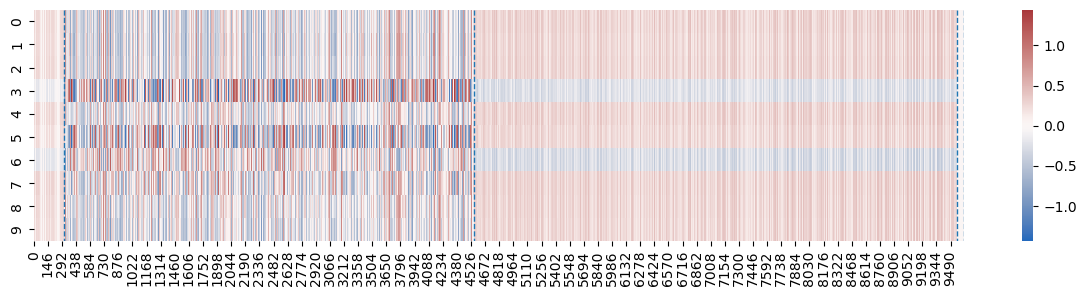

In [7]:
# Extract learned weights from model
weights = model.get_weights()

# Concat all views into one dataframe
w = np.concatenate([weights[k] for k in weights.keys()], axis=1)

lined_heatmap(
    w,
    figsize=(15, 3),
    vlines=[max(x) for x in model.data._feature_idx.values()],
    cmap="vlag",
    center=0,
)